<a href="https://colab.research.google.com/github/sampathi/Python/blob/main/Flight_Cancellation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
def find_top_heights(x):
  x = sorted(x, reverse=True)
  return x[0], x[1], x[2]


y = [25, 35, 15, 16, 30, 45, 37, 39]
print("Top 3 building Heights are: {}".format(find_top_heights(y)))


Top 3 building Heights are: (45, 39, 37)


In [ ]:
def final_amount(n, amount):
  for i in range(n):
    amount = round(amount + 0.05*amount, -3)

  return amount

amount = 100000
final_amount(7, amount)

141000.0

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 71kB/s 


In [ ]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from google.colab import drive    # Only required if working on Google Colab

sns.set()
warnings.filterwarnings('ignore')
%matplotlib inline

## UDFs

In [ ]:
# Create Data audit Report for continuous variables
def cont_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                      x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                     index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                              'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [ ]:
# Create Data audit Report for categorical variables
def cat_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                     index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

## Data Import & Inspection

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Education/flights.txt', sep='|')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TRANSACTIONID      1191805 non-null  int64  
 1   FLIGHTDATE         1191805 non-null  int64  
 2   AIRLINECODE        1191805 non-null  object 
 3   AIRLINENAME        1191805 non-null  object 
 4   TAILNUM            1034988 non-null  object 
 5   FLIGHTNUM          1191805 non-null  int64  
 6   ORIGINAIRPORTCODE  1191805 non-null  object 
 7   ORIGAIRPORTNAME    1191805 non-null  object 
 8   ORIGINCITYNAME     1191805 non-null  object 
 9   ORIGINSTATE        1180963 non-null  object 
 10  ORIGINSTATENAME    1180963 non-null  object 
 11  DESTAIRPORTCODE    1191805 non-null  object 
 12  DESTAIRPORTNAME    1191805 non-null  object 
 13  DESTCITYNAME       1191805 non-null  object 
 14  DESTSTATE          1180967 non-null  object 
 15  DESTSTATENAME      1180967 non-n

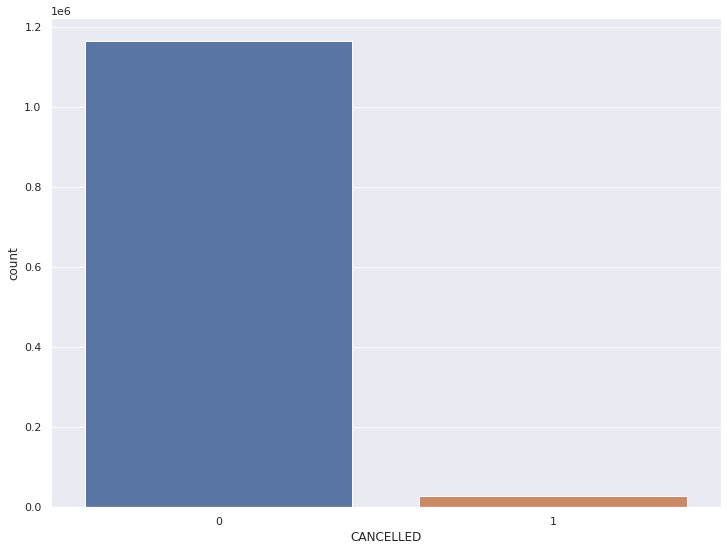

In [ ]:
plt.figure(figsize=(12,9))
ax = sns.countplot(x='CANCELLED', data=data)
plt.show()

In [ ]:
# plt.figure(figsize=(12,9))
# sns.heatmap(data.corr())
# plt.show()
# data.corr()

,TRANSACTIONID,FLIGHTNUM,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE,FLIGHTDATE_YEAR,FLIGHTDATE_MONTH,FLIGHTDATE_DAY
TRANSACTIONID,1.000000,0.353843,0.001056,-0.016572,0.012784,0.040255,-0.017202,-0.011847,0.060961,0.019199,-0.009379,-0.030965,0.100038,0.080977,-0.023424,0.001736,0.059705,0.998261,0.006499,-0.000604
FLIGHTNUM,0.353843,1.000000,0.001483,-0.002624,0.015083,0.017657,-0.000266,-0.020882,0.026365,-0.010857,-0.017112,0.009818,-0.215148,-0.217638,0.015726,0.001996,-0.246202,0.353344,-0.006657,0.000355
CRSDEPTIME,0.001056,0.001483,1.000000,0.951410,0.103802,0.023301,0.928335,0.710707,-0.025417,0.799155,0.705317,0.092654,-0.042719,-0.044403,0.001360,-0.002995,-0.041450,0.000872,0.012272,0.000636
DEPTIME,-0.016572,-0.002624,0.951410,1.000000,0.165658,0.033293,0.979634,0.747018,-0.020868,0.760841,0.736814,0.152172,-0.033766,-0.034299,0.002987,0.000781,-0.034014,-0.016040,-0.007714,-0.003126
DEPDELAY,0.012784,0.015083,0.103802,0.165658,1.000000,0.066689,0.162861,0.078220,0.004436,0.100050,0.070799,0.879716,0.022443,0.028914,0.019749,0.030894,0.017516,0.014516,-0.052394,-0.017646
TAXIOUT,0.040255,0.017657,0.023301,0.033293,0.066689,1.000000,0.063215,0.053998,0.028647,0.044324,0.051497,0.275118,0.162398,0.263457,0.001970,0.013485,0.123663,0.042542,-0.022525,-0.001405
WHEELSOFF,-0.017202,-0.000266,0.928335,0.979634,0.162861,0.063215,1.000000,0.762896,-0.020018,0.759468,0.743648,0.155916,-0.032674,-0.030214,0.001532,0.000549,-0.035146,-0.016888,-0.007074,-0.003204
WHEELSON,-0.011847,-0.020882,0.710707,0.747018,0.078220,0.053998,0.762896,1.000000,-0.002640,0.868142,0.978819,0.076829,0.041845,0.044458,NaN,0.003486,0.037891,-0.011497,-0.006983,-0.000546
TAXIIN,0.060961,0.026365,-0.025417,-0.020868,0.004436,0.028647,-0.020018,-0.002640,1.000000,-0.005489,0.003599,0.059714,0.076485,0.102818,NaN,0.009001,0.059524,0.061723,-0.007697,-0.006332
CRSARRTIME,0.019199,-0.010857,0.799155,0.760841,0.100050,0.044324,0.759468,0.868142,-0.005489,1.000000,0.871942,0.089063,0.040229,0.038366,0.000058,-0.000942,0.035281,0.019051,0.011294,0.002404


In [ ]:
data.head()

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATENAME,DESTAIRPORTCODE,DESTAIRPORTNAME,DESTCITYNAME,DESTSTATE,DESTSTATENAME,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE
0,54548800,20020101,WN,Southwest Airlines Co.: WN,N103@@,1425,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,New Mexico,DAL,DallasTX: Dallas Love Field,Dallas,TX,Texas,1425,1425.0,0.0,8.0,1433.0,1648.0,4.0,1655,1652.0,-3.0,90.0,87.0,F,False,580 miles
1,55872300,20020101,CO,Continental Air Lines Inc.: CO,N83872,150,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,New Mexico,IAH,HoustonTX: George Bush Intercontinental/Houston,Houston,TX,Texas,1130,1136.0,6.0,12.0,1148.0,1419.0,16.0,1426,1435.0,9.0,116.0,119.0,False,F,744 miles
2,54388800,20020101,WN,Southwest Airlines Co.: WN,N334@@,249,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,New Mexico,MCI,Kansas CityMO: Kansas City International,Kansas City,MO,Missouri,1215,1338.0,83.0,7.0,1345.0,1618.0,2.0,1500,1620.0,80.0,105.0,102.0,F,False,718 miles
3,54486500,20020101,WN,Southwest Airlines Co.: WN,N699@@,902,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,New Mexico,LAS,Las VegasNV: McCarran International,Las Vegas,NV,Nevada,1925,1925.0,0.0,5.0,1930.0,1947.0,1.0,1950,1948.0,-2.0,85.0,83.0,0,0,487 miles
4,55878700,20020103,CO,Continental Air Lines Inc.: CO,N58606,234,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,New Mexico,IAH,HoustonTX: George Bush Intercontinental/Houston,Houston,TX,Texas,1455,1453.0,-2.0,11.0,1504.0,1742.0,5.0,1750,1747.0,-3.0,115.0,114.0,F,False,744 miles


In [ ]:
data.tail()

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATENAME,DESTAIRPORTCODE,DESTAIRPORTNAME,DESTCITYNAME,DESTSTATE,DESTSTATENAME,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE
1191800,126750200,20130106,EV,ExpressJet Airlines Inc.: EV,N683BR,5272,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Atlanta,GA,Georgia,DAL,DallasTX: Dallas Love Field,Dallas,TX,Texas,1357,1348.0,-9.0,22.0,1410.0,1500.0,3.0,1523,1503.0,-20.0,146.0,135.0,0,0,721 miles
1191801,127294500,20130106,DL,Delta Air Lines Inc.: DL,N949DL,1711,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Atlanta,GA,Georgia,DFW,Dallas/Fort WorthTX: Dallas/Fort Worth Interna...,Dallas/Fort Worth,TX,Texas,2150,2147.0,-3.0,23.0,2210.0,2307.0,10.0,2321,2317.0,-4.0,151.0,150.0,False,F,731 miles
1191802,127294900,20130106,DL,Delta Air Lines Inc.: DL,N907DE,1810,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Atlanta,GA,Georgia,DFW,Dallas/Fort WorthTX: Dallas/Fort Worth Interna...,Dallas/Fort Worth,TX,Texas,1617,1617.0,0.0,18.0,1635.0,1728.0,9.0,1750,1737.0,-13.0,153.0,140.0,F,False,731 miles
1191803,126594900,20130106,EV,ExpressJet Airlines Inc.: EV,N855AS,5208,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Atlanta,GA,Georgia,FWA,Fort WayneIN: Fort Wayne International,Fort Wayne,IN,Indiana,1516,1514.0,-2.0,21.0,1535.0,1651.0,4.0,1658,1655.0,-3.0,102.0,101.0,False,F,508 miles
1191804,126620300,20130106,EV,ExpressJet Airlines Inc.: EV,N138EV,5549,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Atlanta,GA,Georgia,GSO,Greensboro/High PointNC: Piedmont Triad Intern...,Greensboro/High Point,NC,North Carolina,1452,1458.0,6.0,27.0,1525.0,1611.0,4.0,1609,1615.0,6.0,77.0,77.0,False,False,306 miles


In [ ]:
data.describe(include='all')

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATENAME,DESTAIRPORTCODE,DESTAIRPORTNAME,DESTCITYNAME,DESTSTATE,DESTSTATENAME,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE
count,1.191805e+06,1.191805e+06,1191805,1191805,1034988,1.191805e+06,1191805,1191805,1191805,1180963,1180963,1191805,1191805,1191805,1180967,1180967,1.191805e+06,1.163470e+06,1.163470e+06,1.011833e+06,1.011791e+06,1.010225e+06,1.010320e+06,1.191805e+06,1.161439e+06,1.160545e+06,1.191383e+06,1.160545e+06,1191805,1191805,1191805
unique,NaN,NaN,26,26,13869,NaN,363,363,344,51,51,364,364,345,51,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1706
top,NaN,NaN,WN,Southwest Airlines Co.: WN,UNKNOW,NaN,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Chicago,CA,California,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Chicago,CA,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,F,337 miles
freq,NaN,NaN,189985,189985,7640,NaN,64421,64421,76508,141852,141852,64036,64036,76986,141630,141630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,637289,426572,10113
mean,7.068653e+07,2.003762e+07,NaN,NaN,NaN,1.641101e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.326645e+03,1.341899e+03,7.286340e+00,1.533650e+01,1.363798e+03,1.486798e+03,6.462265e+00,1.490942e+03,1.493244e+03,4.836588e+00,1.266770e+02,1.244874e+02,NaN,NaN,NaN
std,4.677987e+07,7.540976e+04,NaN,NaN,NaN,1.588958e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.776749e+02,4.755364e+02,2.974672e+01,1.038972e+01,4.781433e+02,4.962900e+02,8.397914e+00,4.958673e+02,4.970004e+02,3.182620e+01,6.991184e+01,6.982775e+01,NaN,NaN,NaN
min,1.000000e+02,1.992010e+07,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000e+00,-1.200000e+02,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.500000e+01,1.400000e+01,6.000000e+00,NaN,NaN,NaN
25%,2.979520e+07,1.997090e+07,NaN,NaN,NaN,5.210000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.250000e+02,9.320000e+02,-3.000000e+00,1.000000e+01,9.470000e+02,1.112000e+03,4.000000e+00,1.115000e+03,1.116000e+03,-1.000000e+01,7.500000e+01,7.300000e+01,NaN,NaN,NaN
50%,5.959030e+07,2.003010e+07,NaN,NaN,NaN,1.159000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.325000e+03,1.331000e+03,0.000000e+00,1.300000e+01,1.345000e+03,1.517000e+03,5.000000e+00,1.520000e+03,1.522000e+03,-2.000000e+00,1.080000e+02,1.060000e+02,NaN,NaN,NaN
75%,1.180231e+08,2.011052e+07,NaN,NaN,NaN,2.039000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.725000e+03,1.732000e+03,5.000000e+00,1.800000e+01,1.748000e+03,1.910000e+03,8.000000e+00,1.911000e+03,1.915000e+03,9.000000e+00,1.580000e+02,1.560000e+02,NaN,NaN,NaN


In [ ]:
data.shape

(1191805, 31)

In [ ]:
data.select_dtypes(exclude='object').apply(cont_summary)

,TRANSACTIONID,FLIGHTDATE,FLIGHTNUM,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME
N,1.191805e+06,1.191805e+06,1.191805e+06,1.191805e+06,1.163470e+06,1.163470e+06,1.011833e+06,1.011791e+06,1.010225e+06,1.010320e+06,1.191805e+06,1.161439e+06,1.160545e+06,1.191383e+06,1.160545e+06
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.833500e+04,2.833500e+04,1.799720e+05,1.800140e+05,1.815800e+05,1.814850e+05,0.000000e+00,3.036600e+04,3.126000e+04,4.220000e+02,3.126000e+04
SUM,8.424456e+13,2.388094e+13,1.955872e+09,1.581102e+09,1.561259e+09,8.477438e+06,1.551798e+07,1.379879e+09,1.502000e+09,6.528956e+06,1.776912e+09,1.734312e+09,5.613078e+06,1.509209e+08,1.444732e+08
MEAN,7.068653e+07,2.003762e+07,1.641101e+03,1.326645e+03,1.341899e+03,7.286340e+00,1.533650e+01,1.363798e+03,1.486798e+03,6.462265e+00,1.490942e+03,1.493244e+03,4.836588e+00,1.266770e+02,1.244874e+02
MEDIAN,5.959030e+07,2.003010e+07,1.159000e+03,1.325000e+03,1.331000e+03,0.000000e+00,1.300000e+01,1.345000e+03,1.517000e+03,5.000000e+00,1.520000e+03,1.522000e+03,-2.000000e+00,1.080000e+02,1.060000e+02
STD,4.677987e+07,7.540976e+04,1.588958e+03,4.776749e+02,4.755364e+02,2.974672e+01,1.038972e+01,4.781433e+02,4.962900e+02,8.397914e+00,4.958673e+02,4.970004e+02,3.182620e+01,6.991184e+01,6.982775e+01
VAR,2.188356e+15,5.686633e+09,2.524786e+06,2.281733e+05,2.261349e+05,8.848673e+02,1.079463e+02,2.286211e+05,2.463037e+05,7.052496e+01,2.458844e+05,2.470094e+05,1.012907e+03,4.887666e+03,4.875915e+03
MIN,1.000000e+02,1.992010e+07,1.000000e+00,0.000000e+00,1.000000e+00,-1.200000e+02,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.500000e+01,1.400000e+01,6.000000e+00
P1,1.191904e+06,1.992012e+07,2.200000e+01,1.450000e+02,5.440000e+02,-1.100000e+01,5.000000e+00,5.480000e+02,5.400000e+01,2.000000e+00,1.800000e+01,4.700000e+01,-3.100000e+01,3.900000e+01,3.600000e+01
P5,5.959120e+06,1.993012e+07,1.140000e+02,6.300000e+02,6.320000e+02,-8.000000e+00,6.000000e+00,6.420000e+02,7.300000e+02,2.000000e+00,7.400000e+02,7.360000e+02,-2.100000e+01,5.100000e+01,4.900000e+01


In [ ]:
data.select_dtypes(include='object').apply(cat_summary)

,AIRLINECODE,AIRLINENAME,TAILNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATENAME,DESTAIRPORTCODE,DESTAIRPORTNAME,DESTCITYNAME,DESTSTATE,DESTSTATENAME,CANCELLED,DIVERTED,DISTANCE
N,1191805,1191805,1034988,1191805,1191805,1191805,1180963,1180963,1191805,1191805,1191805,1180967,1180967,1191805,1191805,1191805
NMISS,0,0,156817,0,0,0,10842,10842,0,0,0,10838,10838,0,0,0
MODE,WN,Southwest Airlines Co.: WN,UNKNOW,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Chicago,CA,California,ATL,AtlantaGA: Hartsfield-Jackson Atlanta Internat...,Chicago,CA,California,False,F,337 miles
FREQ,189985,189985,7640,64421,64421,76508,141852,141852,64036,64036,76986,141630,141630,637289,426572,10113
PERCENT,15.94,15.94,0.74,5.41,5.41,6.42,12.01,12.01,5.37,5.37,6.46,11.99,11.99,53.47,35.79,0.85


## Data Cleaning & Preprocessing

In [ ]:
data['DIVERTED'] = data.DIVERTED.map({'False': 0, 'F': 0, '0': 0, 0: 0, 'True': 1, 'T': 1, '1': 1, 1: 1})
data['CANCELLED'] = data.CANCELLED.map({'False': 0, 'F': 0, '0': 0, 0: 0, 'True': 1, 'T': 1, '1': 1, 1: 1})

In [ ]:
# Converting 'FLIGTHDATE' column to datetime
data['FLIGHTDATE'] = data.FLIGHTDATE.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

# Seperating year, month and day into different columns
data['FLIGHTDATE_YEAR'] = data.FLIGHTDATE.dt.year
data['FLIGHTDATE_MONTH'] = data.FLIGHTDATE.dt.month
data['FLIGHTDATE_DAY'] = data.FLIGHTDATE.dt.day

In [ ]:
data['DISTANCE'] = data.DISTANCE.apply(lambda x: int(x.rstrip(' miles')))

In [ ]:
# Copy data for visualization sorted by 'FLIGHTDATE' in ascending order
data_vis = data.sort_values(by='FLIGHTDATE').reset_index(drop=True)

# Copy data for cleaning & preprocessing without the 'FLIGHTDATE' column
df = data.drop('FLIGHTDATE', axis=1)

In [ ]:
# Seperating the target and feature columns
X = df.drop('CANCELLED', axis=1)
y = df.CANCELLED

In [ ]:
# Seperating numerical and categorical variables
X_num = X.select_dtypes(include=['int64', 'float64'])
X_cat = X.select_dtypes(include=['object', 'bool'])

In [ ]:
# Missing imputation with mean for numerical columns
X_num = X_num.apply(lambda x: x.fillna(x.mean()))

# Dropping the categorical columns with missing values
X_cat.drop(X_cat.columns[X_cat.isna().any()].tolist(), axis=1, inplace=True)

In [ ]:
# Label encoding the categorical columns
le = LabelEncoder()
X_cat_enc = X_cat.apply(lambda x: pd.Series(le.fit_transform(x), name=x.name))

In [ ]:
# Consolidating cleaned data
X_cleaned = pd.concat([X_num, X_cat_enc], axis=1)

In [ ]:
# Train-Test Split
train_x_60, test_x_40, train_y_60, test_y_40 = train_test_split(X_cleaned, y, test_size=0.4, random_state=63)
train_x_70, test_x_30, train_y_70, test_y_30 = train_test_split(X_cleaned, y, test_size=0.3, random_state=36)

## EDA

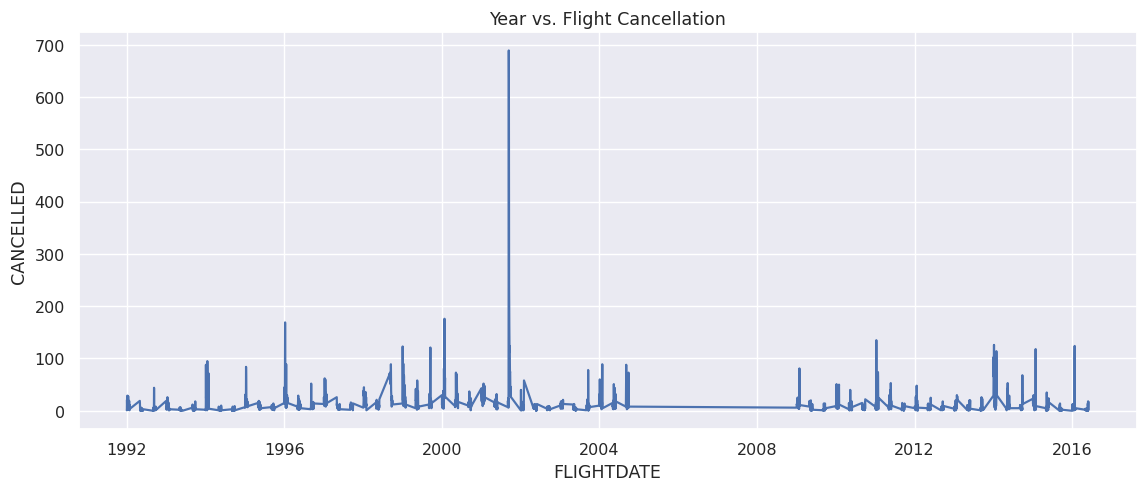

In [ ]:
cancelled_dates = data_vis.groupby('FLIGHTDATE')['CANCELLED'].sum().reset_index()

plt.figure(figsize=(13,5), dpi=105)
plt.title('Year vs. Flight Cancellation')
sns.lineplot(x=cancelled_dates.FLIGHTDATE, y=cancelled_dates.CANCELLED)
plt.show()

# Massive spike in flight cancellations for the year 2002 and almost no cancellations between 2005 - 2009

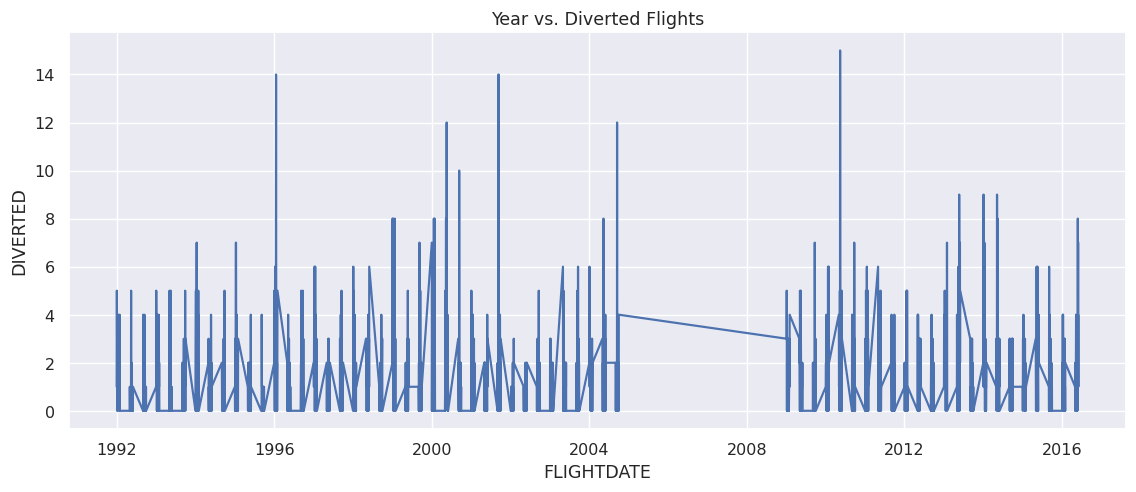

In [ ]:
diverted_dates = data_vis.groupby('FLIGHTDATE')['DIVERTED'].sum().reset_index()

plt.figure(figsize=(13,5), dpi=105)
plt.title('Year vs. Diverted Flights')
sns.lineplot(x=diverted_dates.FLIGHTDATE, y=diverted_dates.DIVERTED)
plt.show()

# Massive spikes in diverted flights for years 1996, 2002 & 2010. Almost constant between 2005 - 2009.

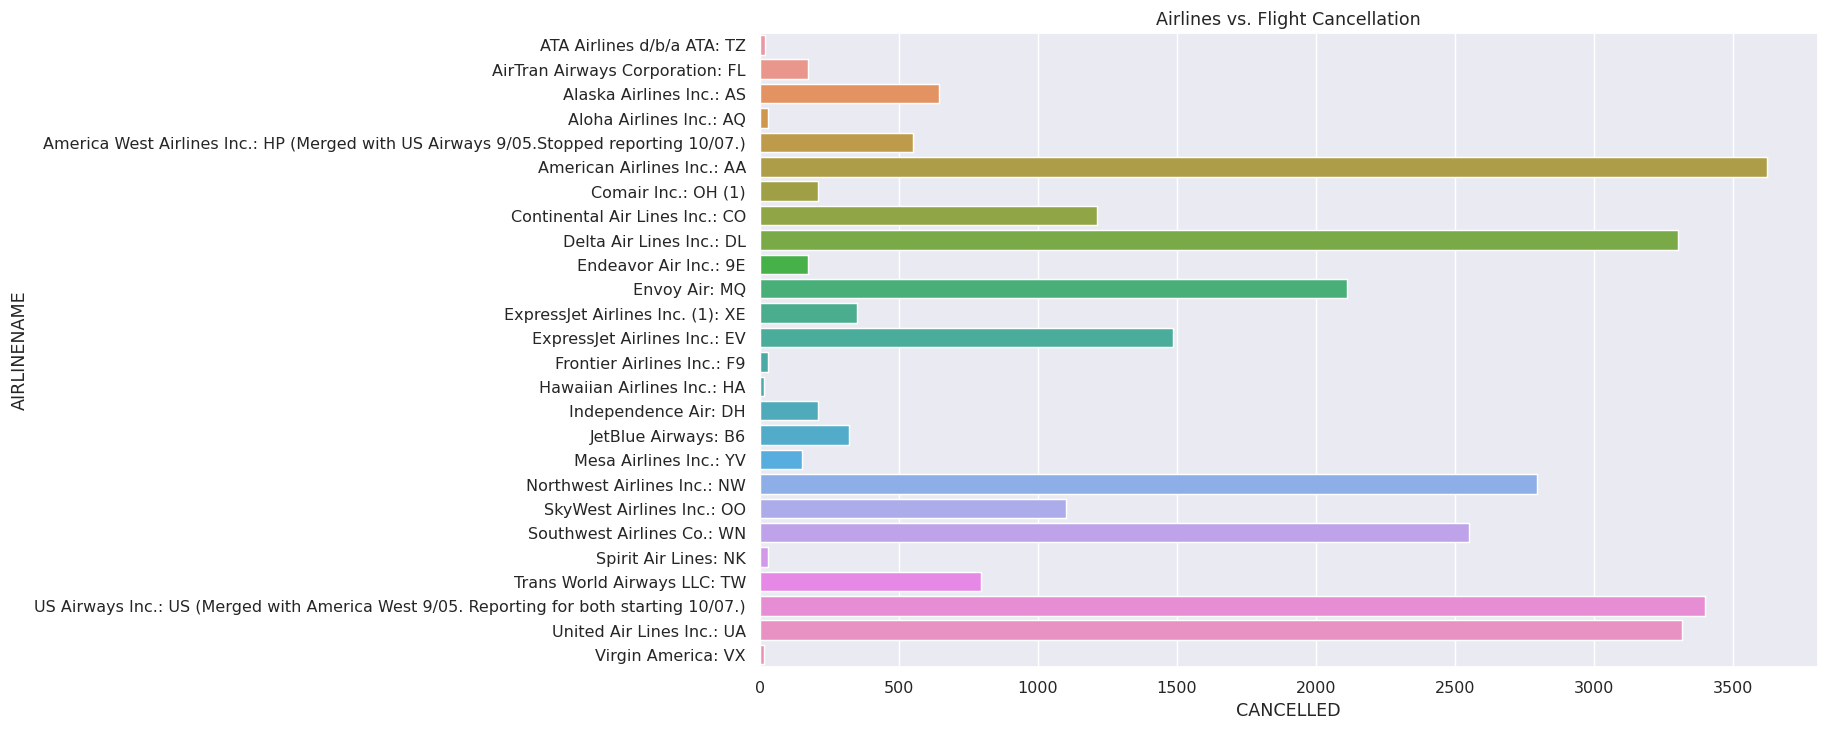

In [ ]:
cancelled_airlines = data_vis.groupby('AIRLINENAME')['CANCELLED'].sum().reset_index()

plt.figure(figsize=(13,8), dpi=105)
plt.title('Airlines vs. Flight Cancellation')
sns.barplot(x=cancelled_airlines.CANCELLED, y=cancelled_airlines.AIRLINENAME)
plt.show()

# American Airlines, US Airways, United Air Lines & Delta Air Lines have the highest flight cancellations
# Hawaiian Airlines, Virgin America & ATA Airlines have the lowest cancellations.

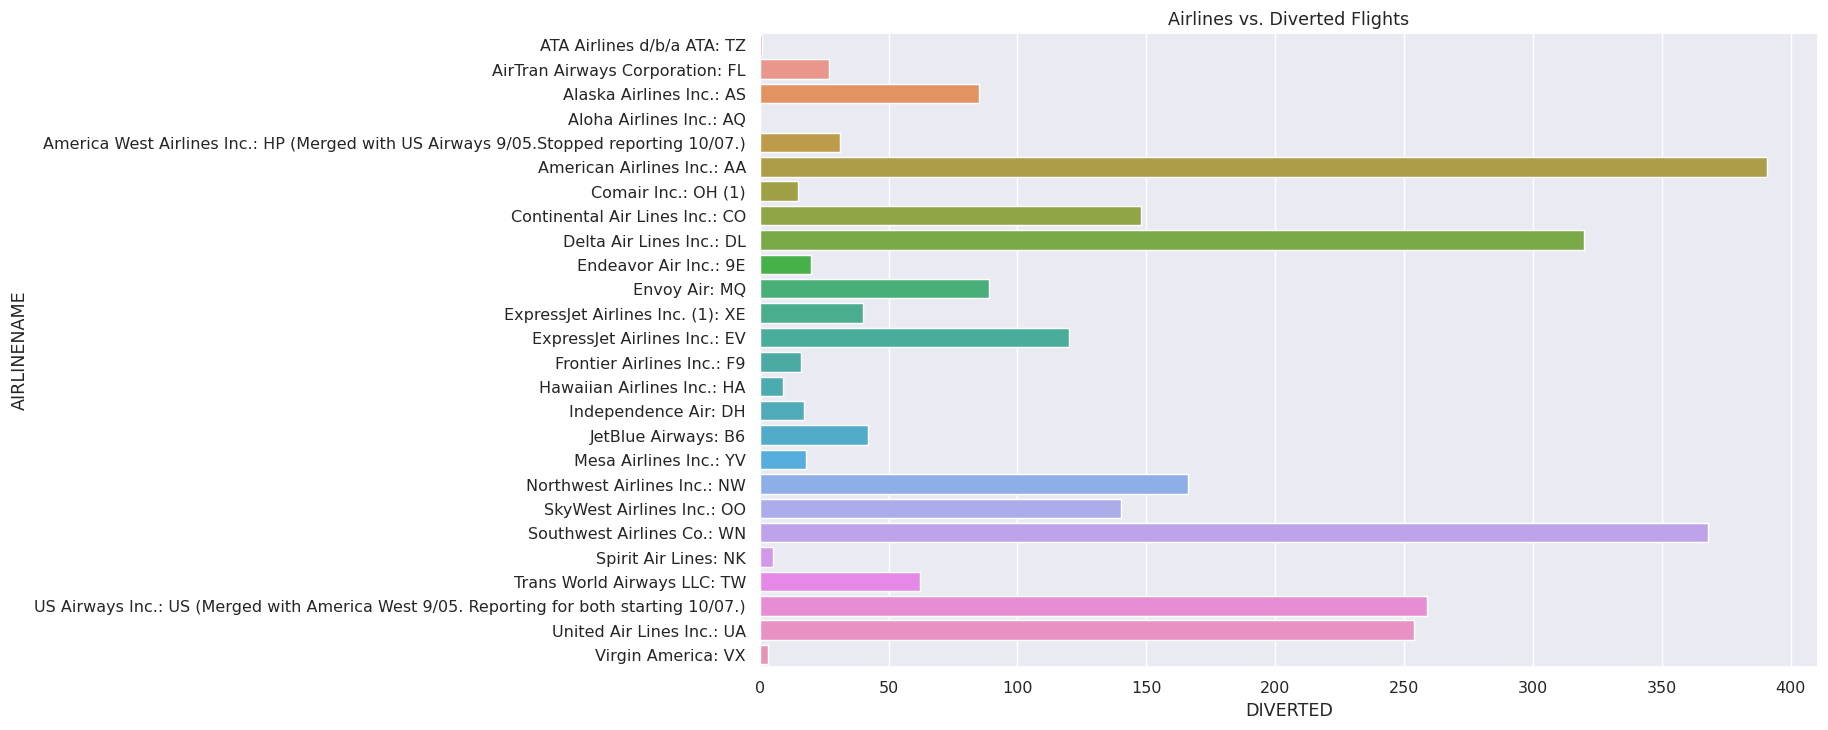

In [ ]:
diverted_airlines = data_vis.groupby('AIRLINENAME')['DIVERTED'].sum().reset_index()

plt.figure(figsize=(13,8), dpi=105)
plt.title('Airlines vs. Diverted Flights')
sns.barplot(x=diverted_airlines.DIVERTED, y=diverted_airlines.AIRLINENAME)
plt.show()

# American Airlines, Southwest Airlines & Delta Airlines have the highest flights diversions.
# ATA Airlines, Aloha Airlines & Virgin America have the lowest diversions.

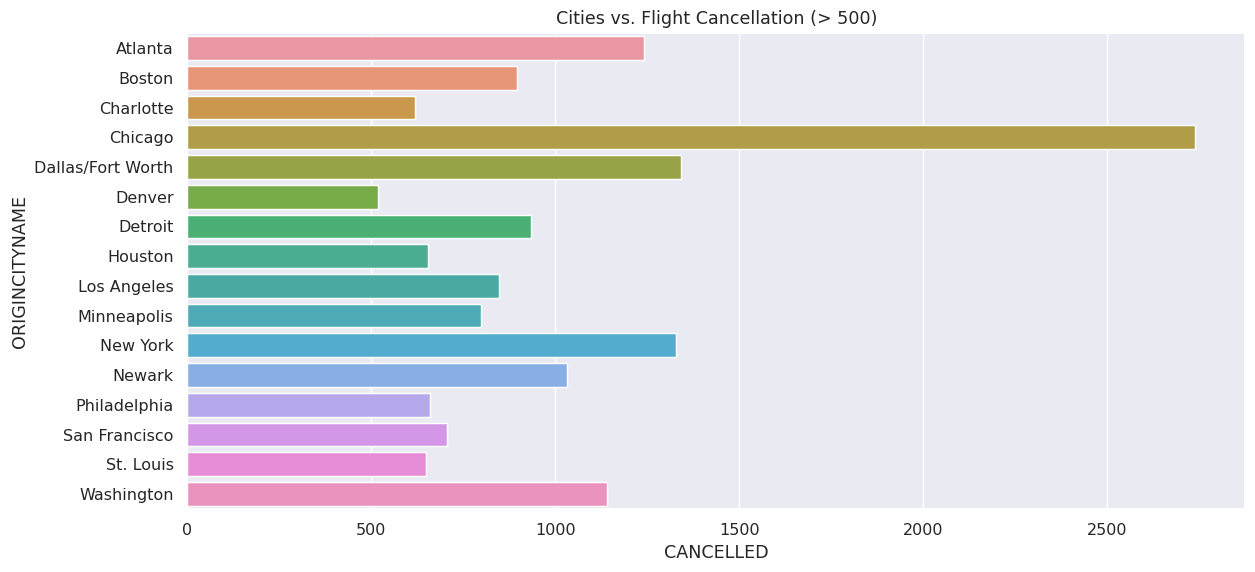

In [ ]:
cancelled_city = data_vis.groupby('ORIGINCITYNAME')['CANCELLED'].sum().reset_index()
cancelled_city_filtered = cancelled_city[cancelled_city.CANCELLED > 500]

plt.figure(figsize=(13,6), dpi=105)
plt.title('Cities vs. Flight Cancellation (> 500)')
sns.barplot(x=cancelled_city_filtered.CANCELLED, y=cancelled_city_filtered.ORIGINCITYNAME)
plt.show()

# Chicago is the city with by far the highest flight cancellations.
# Denver is the lowest.

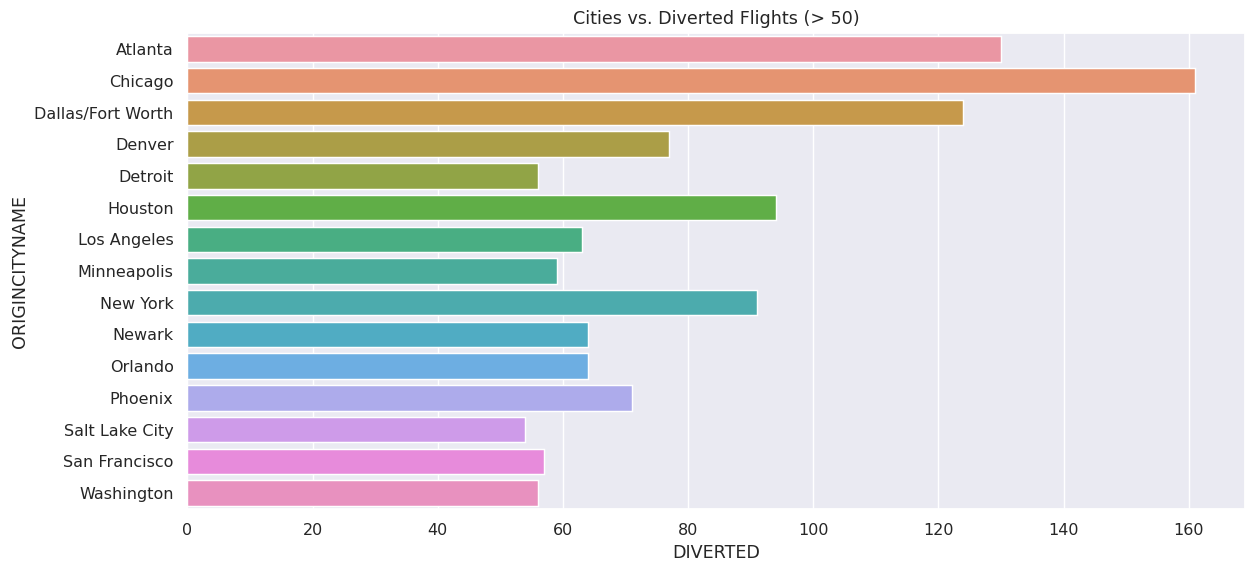

In [ ]:
diverted_city = data_vis.groupby('ORIGINCITYNAME')['DIVERTED'].sum().reset_index()
diverted_city_filtered = diverted_city[diverted_city.DIVERTED > 50]

plt.figure(figsize=(13,6), dpi=105)
plt.title('Cities vs. Diverted Flights (> 50)')
sns.barplot(x=diverted_city_filtered.DIVERTED, y=diverted_city_filtered.ORIGINCITYNAME)
plt.show()

# Chicago, Atlanta & Dallas are the cities with by far the highest flight diversions.
# Salt Lake City is the lowest.

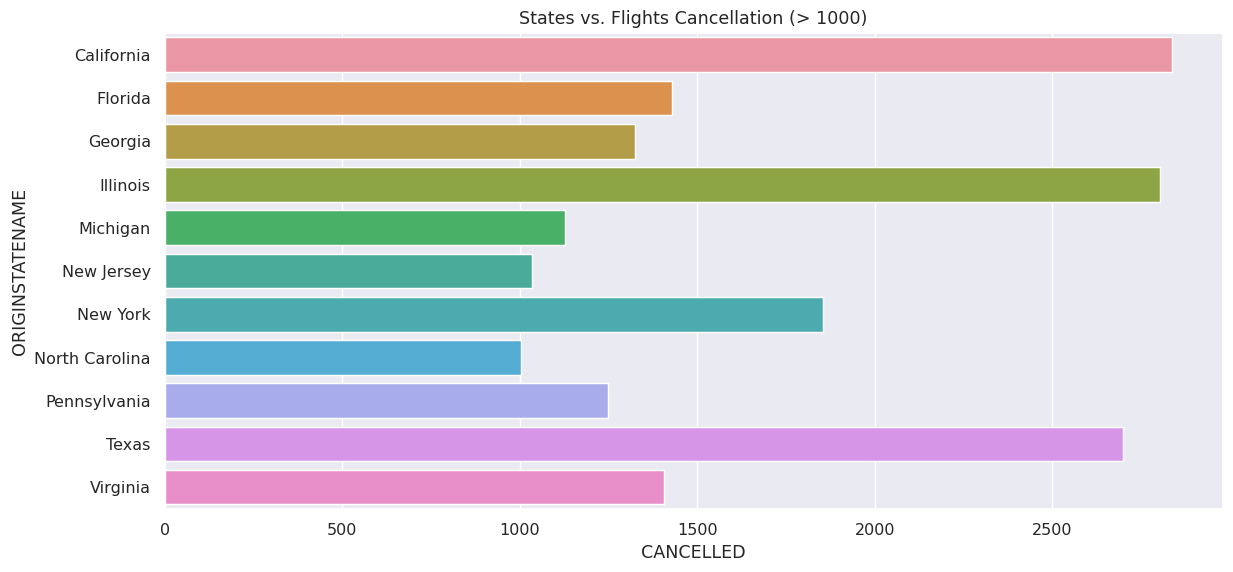

In [ ]:
cancelled_state = data_vis.groupby('ORIGINSTATENAME')['CANCELLED'].sum().reset_index()
cancelled_state_filtered = cancelled_state[cancelled_state.CANCELLED > 1000]

plt.figure(figsize=(13,6), dpi=105)
plt.title('States vs. Flights Cancellation (> 1000)')
sns.barplot(x=cancelled_state_filtered.CANCELLED, y=cancelled_state_filtered.ORIGINSTATENAME)
plt.show()

# California is the state with the highest flight cancellations.
# North Carolina is the lowest.

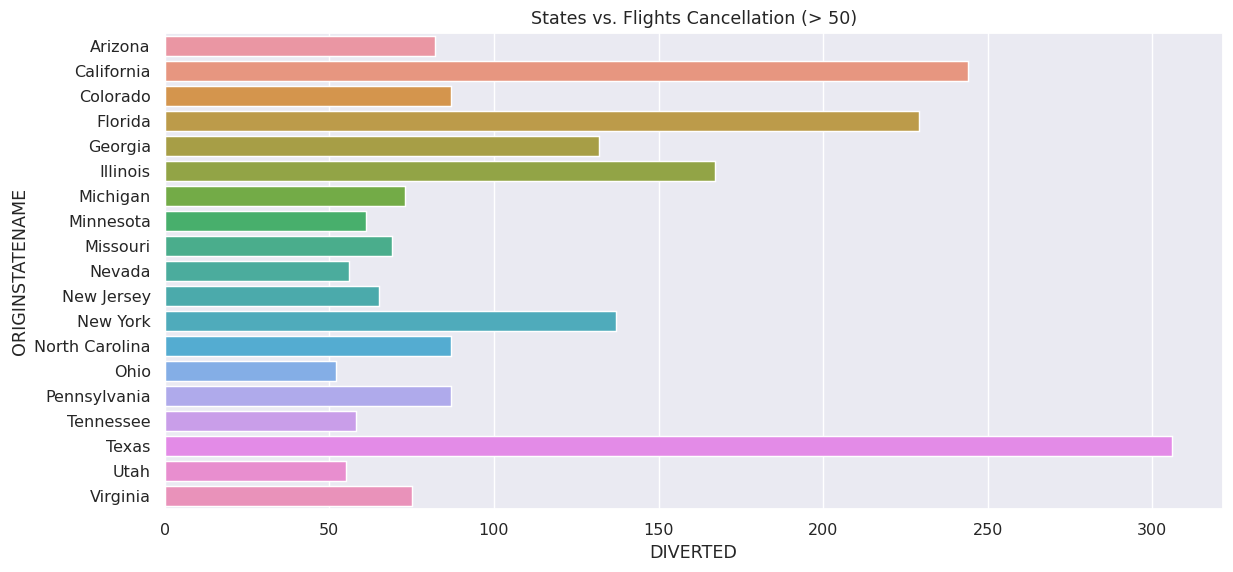

In [ ]:
diverted_state = data_vis.groupby('ORIGINSTATENAME')['DIVERTED'].sum().reset_index()
diverted_state_filtered = diverted_state[diverted_state.DIVERTED > 50]

plt.figure(figsize=(13,6), dpi=105)
plt.title('States vs. Flights Cancellation (> 50)')
sns.barplot(x=diverted_state_filtered.DIVERTED, y=diverted_state_filtered.ORIGINSTATENAME)
plt.show()

# Texas is the state with by far the highest flight diversions. California & Florida are the other two.
# North Carolina is the lowest.

## Modelling

#### 60:40 Split

##### Logistic Regression Model

In [ ]:
logreg = LogisticRegression(random_state=27)
logreg.fit(train_x_60, train_y_60)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=27, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
start_time = time.time()
y_hat = logreg.predict(test_x_40)
end_time_logreg = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    465286
           1       0.00      0.00      0.00     11436

    accuracy                           0.98    476722
   macro avg       0.49      0.50      0.49    476722
weighted avg       0.95      0.98      0.96    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, logreg.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_hat).round(4) * 100)

Train Accuracy: 97.6
Test Accuracy: 97.6


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, logreg.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_hat).round(4) * 100)

Train ROC-AUC: 50.0
Test ROC-AUC: 50.0


In [ ]:
confusion_matrix(test_y_40, y_hat)

array([[465286,      0],
       [ 11436,      0]])

##### KNN Model

In [ ]:
knn = KNeighborsClassifier()
knn.fit(train_x_60, train_y_60)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
start_time = time.time()
y_pred = knn.predict(test_x_40)
end_time_knn = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    465286
           1       0.43      0.08      0.13     11436

    accuracy                           0.98    476722
   macro avg       0.70      0.54      0.56    476722
weighted avg       0.96      0.98      0.97    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, knn.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_pred).round(4) * 100)

Train Accuracy: 97.84
Test Accuracy: 97.54


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, knn.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_pred).round(4) * 100)

Train ROC-AUC: 57.36
Test ROC-AUC: 53.769999999999996


In [ ]:
confusion_matrix(test_y_40, y_pred)

array([[464090,   1196],
       [ 10544,    892]])

##### Decision Tree Model

In [ ]:
dtc = DecisionTreeClassifier(random_state=27)
dtc.fit(train_x_60, train_y_60)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')

In [ ]:
start_time - time.time()
y_pred = dtc.predict(test_x_40)
end_time_dtc = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    465286
           1       1.00      1.00      1.00     11436

    accuracy                           1.00    476722
   macro avg       1.00      1.00      1.00    476722
weighted avg       1.00      1.00      1.00    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, dtc.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, dtc.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_40, y_pred)

array([[465286,      0],
       [     0,  11436]])

##### XGBoost Model

In [ ]:
xgb = XGBClassifier(random_state=27)
xgb.fit(train_x_60, train_y_60)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
start_time = time.time()
y_pred = xgb.predict(test_x_40)
end_time_xgb = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    465286
           1       1.00      1.00      1.00     11436

    accuracy                           1.00    476722
   macro avg       1.00      1.00      1.00    476722
weighted avg       1.00      1.00      1.00    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, xgb.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, xgb.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_40, y_pred)

array([[465286,      0],
       [     0,  11436]])

##### CatBoost Model

In [ ]:
cat = CatBoostClassifier(random_state=27)
cat.fit(train_x_60, train_y_60, verbose=False)

In [ ]:
start_time = time.time()
y_pred = cat.predict(test_x_40)
end_time_cat = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    465286
           1       1.00      1.00      1.00     11436

    accuracy                           1.00    476722
   macro avg       1.00      1.00      1.00    476722
weighted avg       1.00      1.00      1.00    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, cat.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, cat.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_40, y_pred)

array([[465286,      0],
       [     0,  11436]])

##### LightGBM Model

In [ ]:
lgb = LGBMClassifier(random_state=27)
lgb.fit(train_x_60, train_y_60)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=27, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
start_time = time.time()
y_pred = lgb.predict(test_x_40)
end_time_lgb = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_40, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    465286
           1       1.00      1.00      1.00     11436

    accuracy                           1.00    476722
   macro avg       1.00      1.00      1.00    476722
weighted avg       1.00      1.00      1.00    476722



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_60, lgb.predict(train_x_60)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_40, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_60, lgb.predict(train_x_60)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_40, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_40, y_pred)

array([[465286,      0],
       [     0,  11436]])

#### 70:30 Split

##### Logistic Regression Model

In [ ]:
logreg_2 = LogisticRegression(random_state=27)
logreg_2.fit(train_x_70, train_y_70)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=27, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
start_time = time.time()
y_hat = logreg_2.predict(test_x_30)
end_time_logreg_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    348931
           1       0.00      0.00      0.00      8611

    accuracy                           0.98    357542
   macro avg       0.49      0.50      0.49    357542
weighted avg       0.95      0.98      0.96    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, logreg_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_hat).round(4) * 100)

Train Accuracy: 97.6
Test Accuracy: 97.59


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, logreg_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_hat).round(4) * 100)

Train ROC-AUC: 50.0
Test ROC-AUC: 50.0


In [ ]:
confusion_matrix(test_y_30, y_hat)

array([[348931,      0],
       [  8611,      0]])

##### KNN Model

In [ ]:
knn_2 = KNeighborsClassifier()
knn_2.fit(train_x_70, train_y_70)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
start_time = time.time()
y_pred = knn_2.predict(test_x_30)
end_time_knn_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    348931
           1       0.45      0.08      0.14      8611

    accuracy                           0.98    357542
   macro avg       0.72      0.54      0.56    357542
weighted avg       0.97      0.98      0.97    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, knn_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_pred).round(4) * 100)

Train Accuracy: 97.87
Test Accuracy: 97.55


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, knn_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_pred).round(4) * 100)

Train ROC-AUC: 57.98
Test ROC-AUC: 54.06999999999999


In [ ]:
confusion_matrix(test_y_30, y_pred)

array([[348060,    871],
       [  7888,    723]])

##### Decision Tree Model

In [ ]:
dtc_2 = DecisionTreeClassifier(random_state=27)
dtc_2.fit(train_x_70, train_y_70)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')

In [ ]:
start_time - time.time()
y_pred = dtc_2.predict(test_x_30)
end_time_dtc_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    348931
           1       1.00      1.00      1.00      8611

    accuracy                           1.00    357542
   macro avg       1.00      1.00      1.00    357542
weighted avg       1.00      1.00      1.00    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, dtc_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, dtc_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_30, y_pred)

array([[348931,      0],
       [     0,   8611]])

##### XGBoost Model

In [ ]:
xgb_2 = XGBClassifier(random_state=27)
xgb_2.fit(train_x_70, train_y_70)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
start_time = time.time()
y_pred = xgb_2.predict(test_x_30)
end_time_xgb_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    348931
           1       1.00      1.00      1.00      8611

    accuracy                           1.00    357542
   macro avg       1.00      1.00      1.00    357542
weighted avg       1.00      1.00      1.00    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, xgb_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, xgb_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_30, y_pred)

array([[348931,      0],
       [     0,   8611]])

##### CatBoost Model

In [ ]:
cat_2 = CatBoostClassifier(random_state=27)
cat_2.fit(train_x_70, train_y_70, verbose=False)

In [ ]:
start_time = time.time()
y_pred = cat_2.predict(test_x_30)
end_time_cat_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    348931
           1       1.00      1.00      1.00      8611

    accuracy                           1.00    357542
   macro avg       1.00      1.00      1.00    357542
weighted avg       1.00      1.00      1.00    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, cat_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, cat_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_30, y_pred)

array([[348931,      0],
       [     0,   8611]])

##### LightGBM Model

In [ ]:
lgb_2 = LGBMClassifier(random_state=27)
lgb_2.fit(train_x_70, train_y_70)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=27, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
start_time = time.time()
y_pred = lgb_2.predict(test_x_30)
end_time_lgb_2 = round(time.time() - start_time, 4)

In [ ]:
print(classification_report(test_y_30, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    348931
           1       1.00      1.00      1.00      8611

    accuracy                           1.00    357542
   macro avg       1.00      1.00      1.00    357542
weighted avg       1.00      1.00      1.00    357542



In [ ]:
print('Train Accuracy:', accuracy_score(train_y_70, lgb_2.predict(train_x_70)).round(4) * 100)
print('Test Accuracy:', accuracy_score(test_y_30, y_pred).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 100.0


In [ ]:
print('Train ROC-AUC:', roc_auc_score(train_y_70, lgb_2.predict(train_x_70)).round(4) * 100)
print('Test ROC-AUC:', roc_auc_score(test_y_30, y_pred).round(4) * 100)

Train ROC-AUC: 100.0
Test ROC-AUC: 100.0


In [ ]:
confusion_matrix(test_y_30, y_pred)

array([[348931,      0],
       [     0,   8611]])

##### Model Comparison

In [ ]:
# Comparing the results obtained from different models with default parameters 
# 60:40 split
df_compare = pd.DataFrame({'Model': [type(logreg).__name__, type(knn).__name__, type(dtc).__name__,
                                     type(xgb).__name__, type(cat).__name__, type(lgb).__name__],
                           'Train Accuracy': [logreg.score(train_x_60, train_y_60).round(4) * 100, 
                                              knn.score(train_x_60, train_y_60).round(4) * 100, dtc.score(train_x_60, train_y_60).round(4) * 100,
                                              xgb.score(train_x_60, train_y_60).round(4) * 100, 
                                              cat.score(train_x_60, train_y_60).round(4) * 100, lgb.score(train_x_60, train_y_60).round(4) * 100],
                           'Test Accuracy': [logreg.score(test_x_40, test_y_40).round(4) * 100, 
                                              knn.score(test_x_40, test_y_40).round(4) * 100, dtc.score(test_x_40, test_y_40).round(4) * 100,
                                             xgb.score(test_x_40, test_y_40).round(4) * 100, 
                                              cat.score(test_x_40, test_y_40).round(4) * 100, lgb.score(test_x_40, test_y_40).round(4) * 100],
                           'Train ROC-AUC': [roc_auc_score(train_y_60, logreg.predict(train_x_60)).round(4) * 100,
                                             roc_auc_score(train_y_60, knn.predict(train_x_60)).round(4) * 100,
                                             roc_auc_score(train_y_60, dtc.predict(train_x_60)).round(4) * 100,
                                             roc_auc_score(train_y_60, xgb.predict(train_x_60)).round(4) * 100,
                                             roc_auc_score(train_y_60, cat.predict(train_x_60)).round(4) * 100,
                                             roc_auc_score(train_y_60, lgb.predict(train_x_60)).round(4) * 100],
                           'Test ROC-AUC': [roc_auc_score(test_y_40, logreg.predict(test_x_40)).round(4) * 100,
                                            roc_auc_score(test_y_40, knn.predict(test_x_40)).round(4) * 100,
                                            roc_auc_score(test_y_40, dtc.predict(test_x_40)).round(4) * 100,
                                            roc_auc_score(test_y_40, xgb.predict(test_x_40)).round(4) * 100,
                                            roc_auc_score(test_y_40, cat.predict(test_x_40)).round(4) * 100,
                                            roc_auc_score(test_y_40, lgb.predict(test_x_40)).round(4) * 100],
                           'Time of Inference': [end_time_logreg, end_time_knn, end_time_dtc,
                                                 end_time_xgb, end_time_cat, end_time_lgb]})

# 70:30 split
df_compare_2 = pd.DataFrame({'Model': [type(logreg_2).__name__, type(knn_2).__name__, type(dtc_2).__name__,
                                     type(xgb_2).__name__, type(cat_2).__name__, type(lgb_2).__name__],
                           'Train Accuracy': [logreg_2.score(train_x_70, train_y_70).round(4) * 100, 
                                              knn_2.score(train_x_70, train_y_70).round(4) * 100, dtc_2.score(train_x_70, train_y_70).round(4) * 100,
                                              xgb_2.score(train_x_70, train_y_70).round(4) * 100, 
                                              cat_2.score(train_x_70, train_y_70).round(4) * 100, lgb_2.score(train_x_70, train_y_70).round(4) * 100],
                           'Test Accuracy': [logreg_2.score(test_x_30, test_y_30).round(4) * 100, 
                                              knn_2.score(test_x_30, test_y_30).round(4) * 100, dtc_2.score(test_x_30, test_y_30).round(4) * 100,
                                             xgb_2.score(test_x_30, test_y_30).round(4) * 100, 
                                              cat_2.score(test_x_30, test_y_30).round(4) * 100, lgb_2.score(test_x_30, test_y_30).round(4) * 100],
                           'Train ROC-AUC': [roc_auc_score(train_y_70, logreg_2.predict(train_x_70)).round(4) * 100,
                                             roc_auc_score(train_y_70, knn_2.predict(train_x_70)).round(4) * 100,
                                             roc_auc_score(train_y_70, dtc_2.predict(train_x_70)).round(4) * 100,
                                             roc_auc_score(train_y_70, xgb_2.predict(train_x_70)).round(4) * 100,
                                             roc_auc_score(train_y_70, cat_2.predict(train_x_70)).round(4) * 100,
                                             roc_auc_score(train_y_70, lgb_2.predict(train_x_70)).round(4) * 100],
                           'Test ROC-AUC': [roc_auc_score(test_y_30, logreg_2.predict(test_x_30)).round(4) * 100,
                                            roc_auc_score(test_y_30, knn_2.predict(test_x_30)).round(4) * 100,
                                            roc_auc_score(test_y_30, dtc_2.predict(test_x_30)).round(4) * 100,
                                            roc_auc_score(test_y_30, xgb_2.predict(test_x_30)).round(4) * 100,
                                            roc_auc_score(test_y_30, cat_2.predict(test_x_30)).round(4) * 100,
                                            roc_auc_score(test_y_30, lgb_2.predict(test_x_30)).round(4) * 100],
                           'Time of Inference': [end_time_logreg_2, end_time_knn_2, end_time_dtc_2,
                                                 end_time_xgb_2, end_time_cat_2, end_time_lgb_2]})

In [ ]:
df_compare.style.set_caption("60:40 Split")

,Model,Train Accuracy,Test Accuracy,Train ROC-AUC,Test ROC-AUC,Time of Inference
0,LogisticRegression,97.600000,97.600000,50.000000,50.000000,0.032100
1,KNeighborsClassifier,97.840000,97.540000,57.360000,53.770000,27.058100
2,DecisionTreeClassifier,100.000000,100.000000,100.000000,100.000000,112.876800
3,XGBClassifier,100.000000,100.000000,100.000000,100.000000,0.640400
4,CatBoostClassifier,100.000000,100.000000,100.000000,100.000000,0.448700
5,LGBMClassifier,100.000000,100.000000,100.000000,100.000000,1.790100


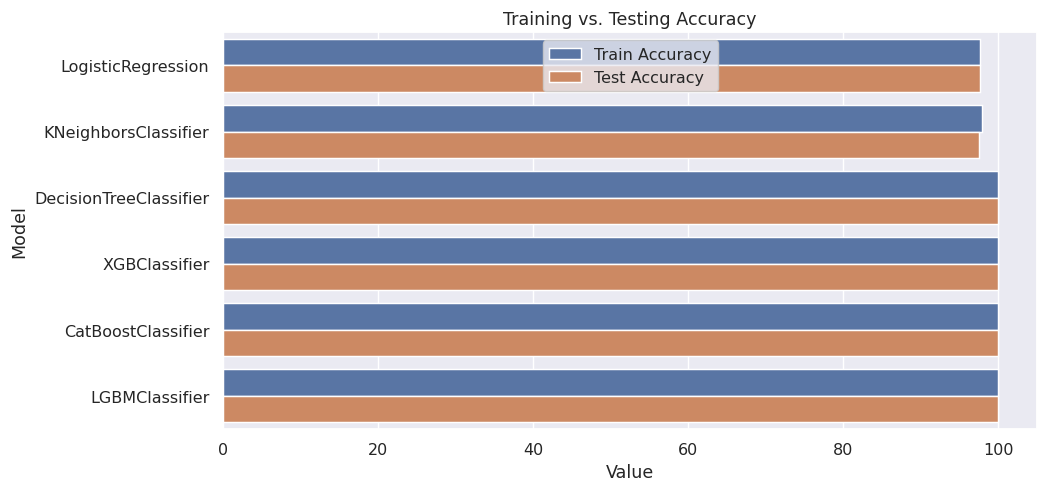

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5), dpi=105)
tidy = df_compare[['Model', 'Train Accuracy', 'Test Accuracy']].melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Value', y='Model', hue='Variable', data=tidy, ax=ax1)
plt.title('Training vs. Testing Accuracy')
plt.legend(loc='upper center')
plt.show()

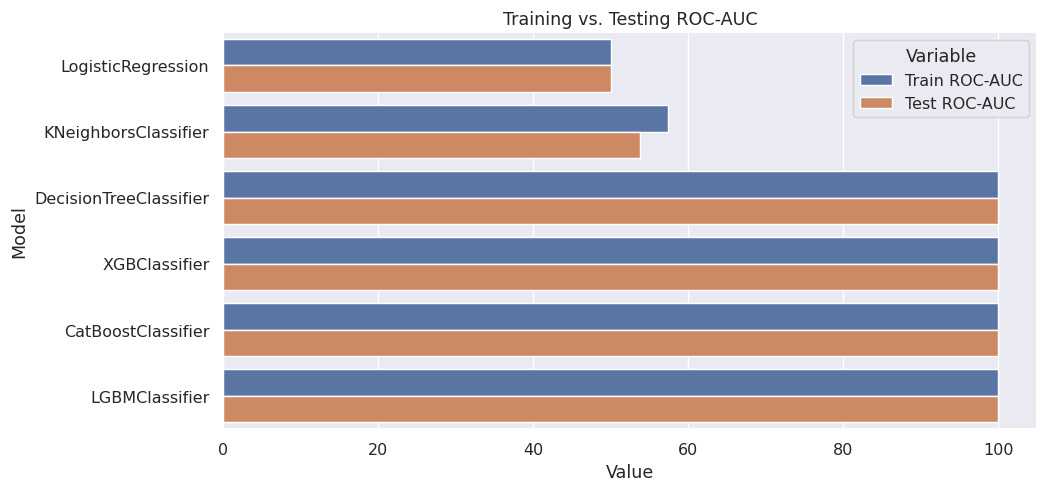

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5), dpi=105)
tidy = df_compare[['Model', 'Train ROC-AUC', 'Test ROC-AUC']].melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Value', y='Model', hue='Variable', data=tidy, ax=ax1)
plt.title('Training vs. Testing ROC-AUC')
plt.show()

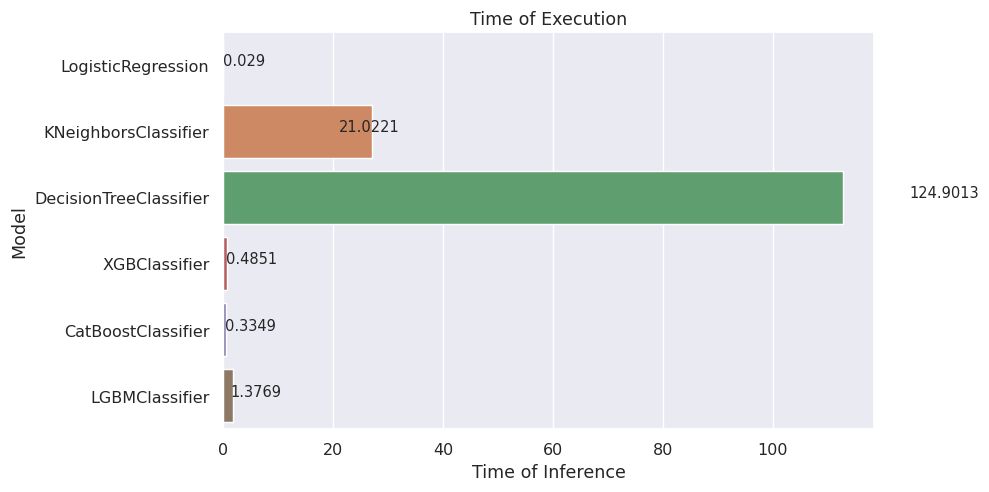

In [ ]:
plt.figure(figsize=(8,5), dpi=105)
sns.barplot(x='Time of Inference', y='Model', data=df_compare)

for index, value in enumerate(df_compare_2['Time of Inference']):
    plt.text(value, index, str(value))

plt.title('Time of Execution')
plt.show()

In [ ]:
df_compare_2.style.set_caption("70:30 Split")

,Model,Train Accuracy,Test Accuracy,Train ROC-AUC,Test ROC-AUC,Time of Inference
0,LogisticRegression,97.600000,97.590000,50.000000,50.000000,0.029000
1,KNeighborsClassifier,97.870000,97.550000,57.980000,54.070000,21.022100
2,DecisionTreeClassifier,100.000000,100.000000,100.000000,100.000000,124.901300
3,XGBClassifier,100.000000,100.000000,100.000000,100.000000,0.485100
4,CatBoostClassifier,100.000000,100.000000,100.000000,100.000000,0.334900
5,LGBMClassifier,100.000000,100.000000,100.000000,100.000000,1.376900


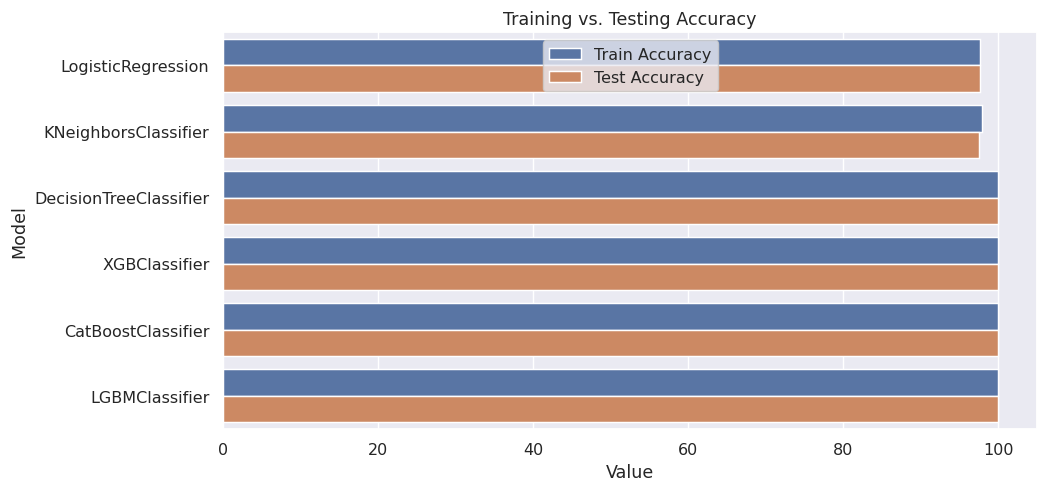

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5), dpi=105)
tidy = df_compare_2[['Model', 'Train Accuracy', 'Test Accuracy']].melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Value', y='Model', hue='Variable', data=tidy, ax=ax1)
plt.title('Training vs. Testing Accuracy')
plt.legend(loc='upper center')
plt.show()

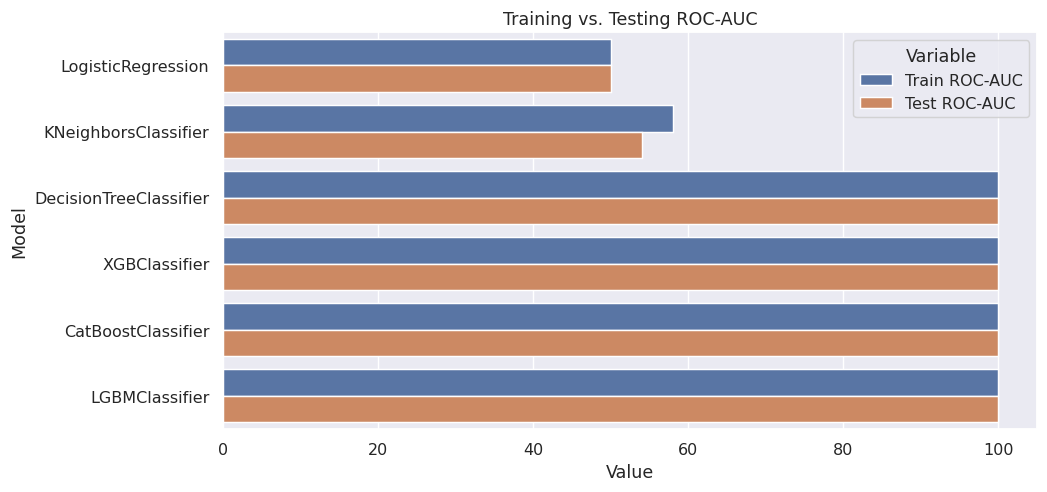

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5), dpi=105)
tidy = df_compare_2[['Model', 'Train ROC-AUC', 'Test ROC-AUC']].melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Value', y='Model', hue='Variable', data=tidy, ax=ax1)
plt.title('Training vs. Testing ROC-AUC')
plt.show()

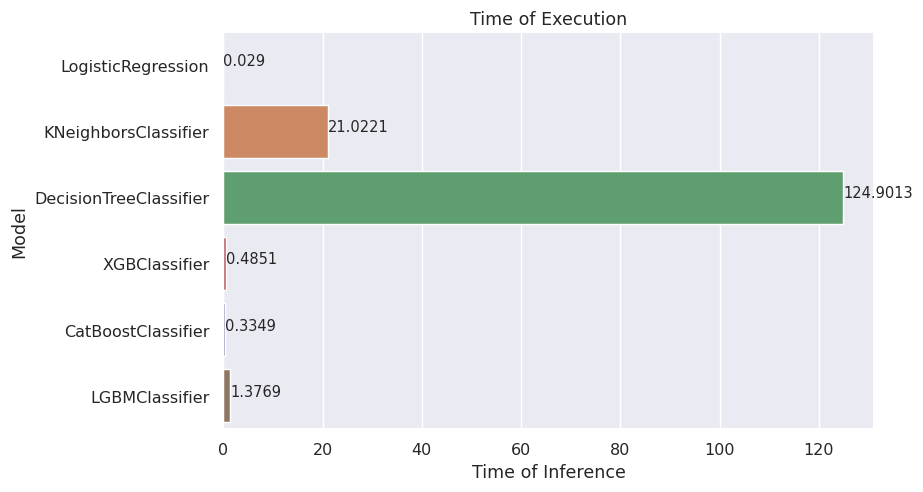

In [ ]:
plt.figure(figsize=(8,5), dpi=105)
sns.barplot(x='Time of Inference', y='Model', data=df_compare_2)

for index, value in enumerate(df_compare_2['Time of Inference']):
    plt.text(value, index, str(value))

plt.title('Time of Execution')
plt.show()

Considering the training and testing accuracy (hence overfitting), ROC-AUC scores and the time of execution of all the models, CatBoost Classifier model gives the best and the most efficient results.